<a href="https://colab.research.google.com/github/ancestor9/2025_Winter_Deep-Learning-with-TensorFlow/blob/main/20260107_03_Image%20Classification/14_3_local_patch_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

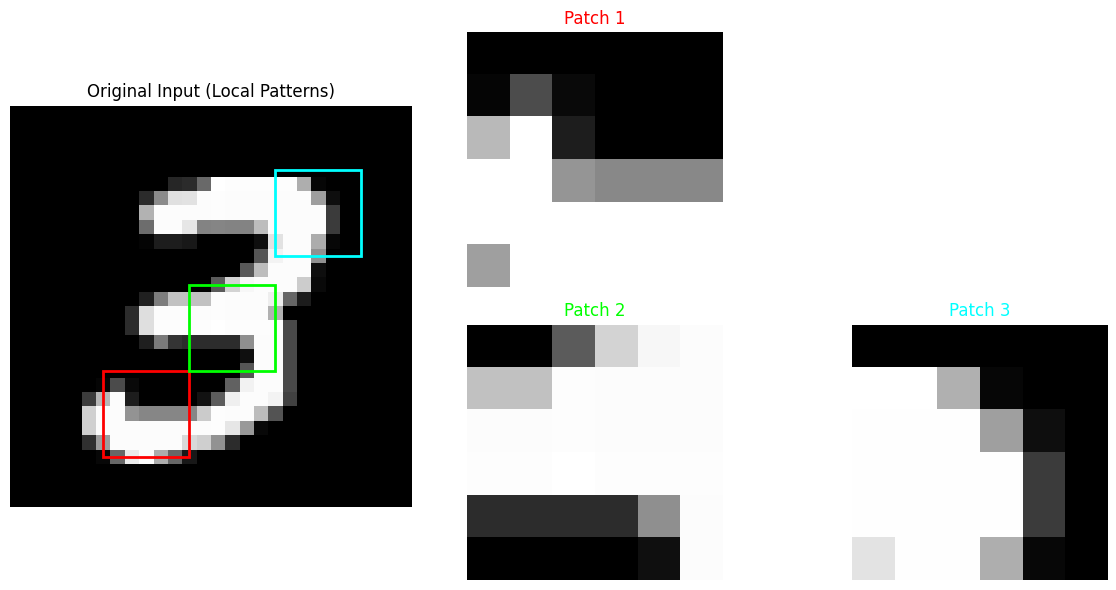

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras.datasets import mnist

# 1. MNIST 데이터 로드 및 샘플 선택
(x_train, y_train), _ = mnist.load_data()
sample_idx = 7  # 무작위 추출 선택
image = x_train[sample_idx]

# 2. 추출할 로컬 패턴(패치)의 위치와 크기 정의 (y, x, size)
# 이미지의 에지와 질감이 나타나는 세 곳을 임의로 지정합니다.
patch_definitions = [
    (18, 6, 6),   # 왼쪽 하단 에지
    (12, 12, 6),  # 중앙 교차점/질감
    (4, 18, 6)    # 오른쪽 상단 에지
]

# 3. 시각화 설정
fig = plt.figure(figsize=(12, 6))
ax_main = plt.subplot2grid((2, 3), (0, 0), rowspan=2)
ax_patches = [plt.subplot2grid((2, 3), (1, i)) for i in range(1, 3)] # 아래쪽 패치들
# 추가 패치를 위해 레이아웃 조정
ax_patch3 = plt.subplot2grid((2, 3), (0, 1))
ax_all_patches = [ax_patch3, ax_patches[0], ax_patches[1]]

# 4. 원본 이미지 표시 및 패치 영역 표시
ax_main.imshow(image, cmap='gray')
ax_main.set_title("Original Input (Local Patterns)", fontsize=12)
ax_main.axis('off')

colors = ['red', 'lime', 'cyan']

for i, (y, x, size) in enumerate(patch_definitions):
    # 패치 추출 (Slicing)
    patch = image[y:y+size, x:x+size]

    # 원본 이미지에 사각형 표시
    rect = patches.Rectangle((x, y), size, size, linewidth=2, edgecolor=colors[i], facecolor='none')
    ax_main.add_patch(rect)

    # 추출된 패치 시각화
    ax_all_patches[i].imshow(patch, cmap='gray')
    ax_all_patches[i].set_title(f"Patch {i+1}", color=colors[i])
    ax_all_patches[i].axis('off')

plt.tight_layout()
plt.show()

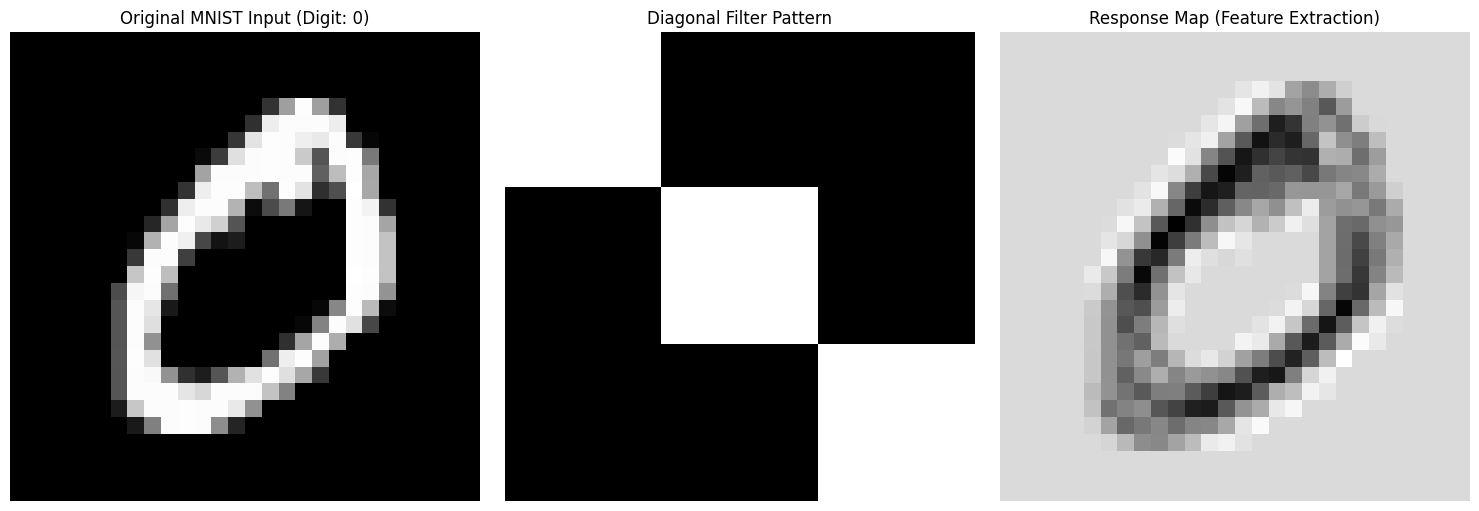

In [ ]:
# 2. 숫자 '0' 데이터 하나 선택 (이미지와 유사한 샘플 찾기)
digit_0_index = np.where(y_train == 0)[0][0]
input_image = x_train[digit_0_index]

# 3. 별첨 이미지와 유사한 대각선 필터 정의 (3x3)
# 대각선 방향(\)으로 높은 값을 갖는 필터
single_filter = np.array([
    [ 1, -1, -1],
    [-1,  1, -1],
    [-1, -1,  1]
])

# 4. 합성곱 연산 수행 (응답 맵 생성)
# 이미지의 각 부분과 필터를 곱해 더하여 특징을 추출합니다.
response_map = convolve2d(input_image, single_filter, mode='same')

# 5. 시각화
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 원본 MNIST 입력
axes[0].imshow(input_image, cmap='gray')
axes[0].set_title(f"Original MNIST Input (Digit: 0)", fontsize=12)
axes[0].axis('off')

# 필터 (대각선 패턴)
axes[1].imshow(single_filter, cmap='gray')
axes[1].set_title("Diagonal Filter Pattern", fontsize=12)
axes[1].axis('off')

# 결과 응답 맵
# 필터의 대각선 방향과 일치하는 부분들이 밝게 강조됩니다.
axes[2].imshow(response_map, cmap='gray')
axes[2].set_title("Response Map (Feature Extraction)", fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.show()

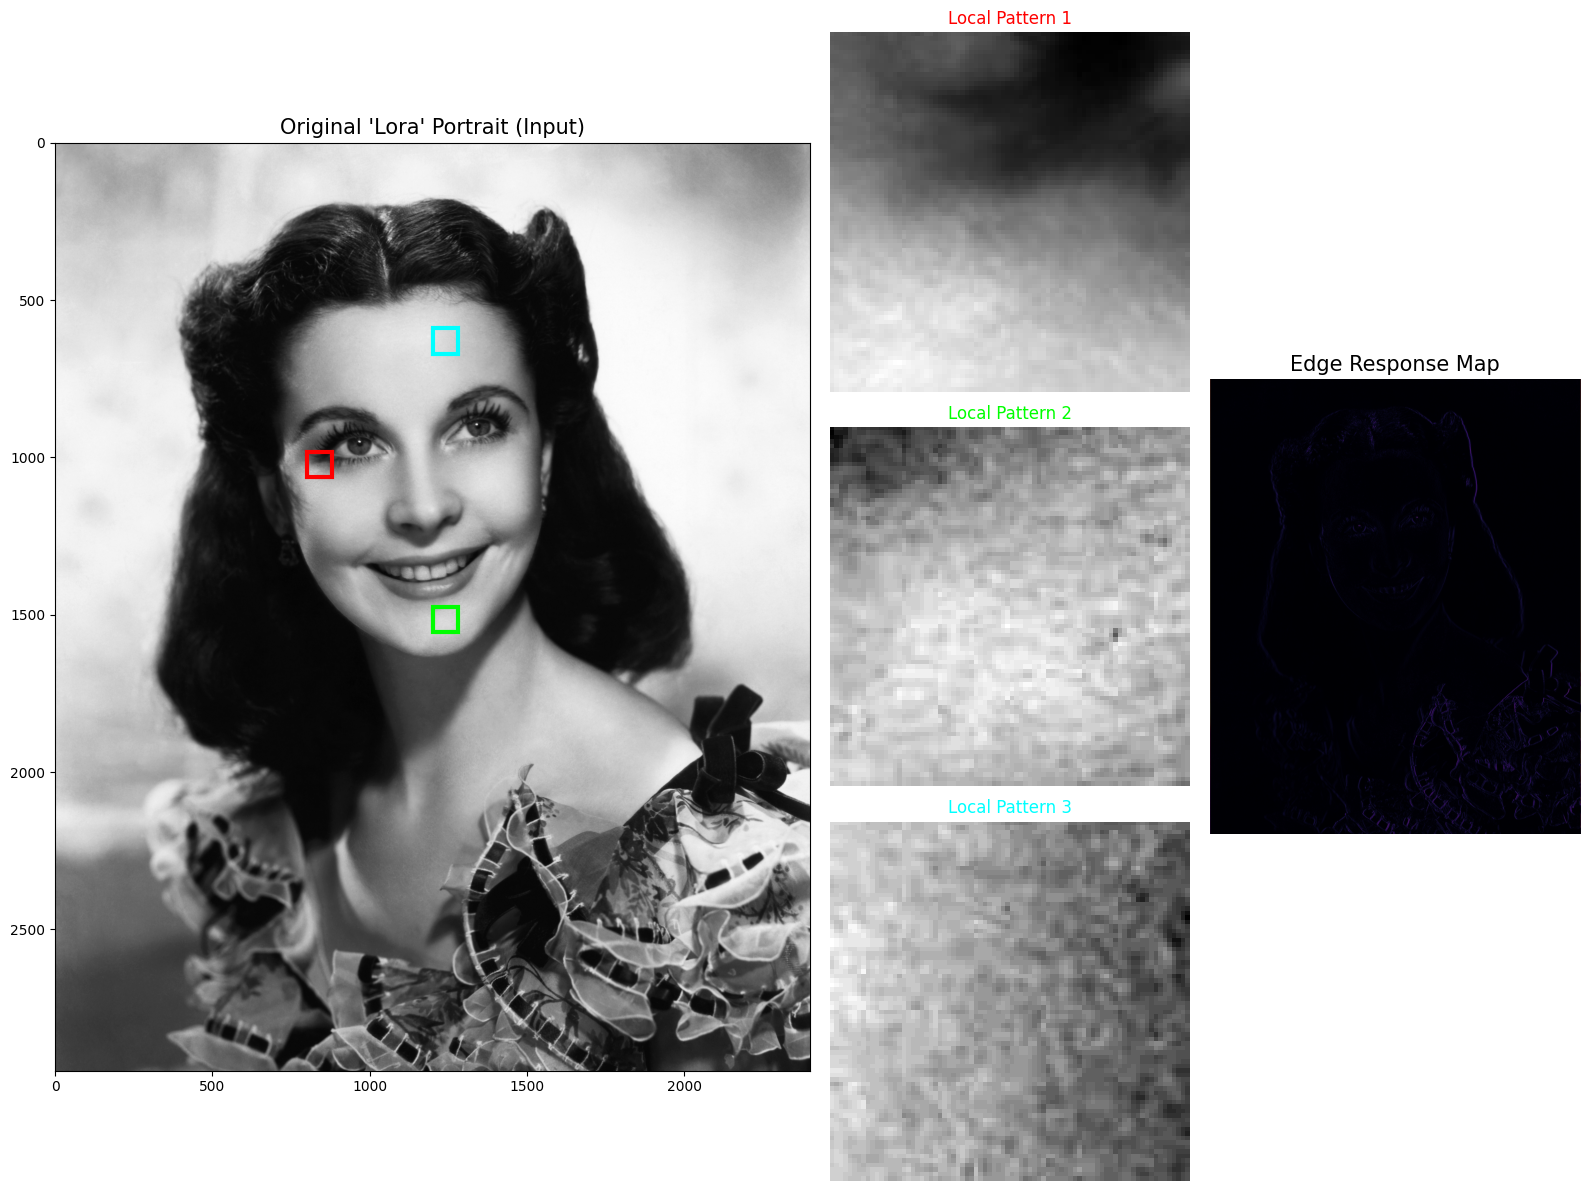

In [ ]:
import requests
from PIL import Image, UnidentifiedImageError # UnidentifiedImageError 임포트 추가
from io import BytesIO
from scipy.signal import convolve2d

# 1. 'Lora' 샘플 이미지 로드 (인터넷 이미지 URL 사용 예시)
# 실제 로컬 파일이 있다면 Image.open("lora_image.jpg")로 대체 가능합니다.
# 수정: 'thumb' 경로를 제거하여 더 직접적인 이미지 URL 사용
url = "https://upload.wikimedia.org/wikipedia/commons/b/b6/Vivien_Leigh_Scarlet.jpg"
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
response = requests.get(url, headers=headers)

# 요청이 성공했는지, 그리고 콘텐츠 타입이 이미지인지 확인합니다.
if response.status_code == 200 and 'image' in response.headers.get('Content-Type', ''):
    try:
        img = Image.open(BytesIO(response.content)).convert('L') # 연산을 위해 흑백으로 변환
        img_array = np.array(img)

        # 2. 로컬 패턴(패치) 추출 위치 정의 (y, x, size)
        # 인물의 특징적인 부분(눈, 입술, 머리카락 질감 등)을 선택합니다.
        h, w = img_array.shape
        patches_coords = [
            (h//3, w//3, 80),    # 예: 왼쪽 눈 주변
            (h//2, w//2, 80),    # 예: 코/입술 주변
            (h//5, w//2, 80)     # 예: 머리카락 질감
        ]

        # 3. 필터 정의 (에지 및 질감 탐지용 Sobel 필터)
        # 실제 CNN의 필터처럼 수직/수평선의 특징을 추출합니다.
        edge_filter = np.array([
            [-1, 0, 1],
            [-2, 0, 2],
            [-1, 0, 1]
        ])

        # 4. 합성곱 연산 (Response Map 생성)
        response_map = convolve2d(img_array, edge_filter, mode='same')

        # 5. 시각화
        # GridSpec을 (3, 4)로 변경하여 3개의 패치와 메인 이미지/응답 맵을 배치할 공간 확보
        fig = plt.figure(figsize=(16, 12)) # Figure size 조정

        # 원본 이미지와 추출 영역 표시
        # rowspan을 3으로 변경하여 3개의 행에 걸쳐 표시
        ax_main = plt.subplot2grid((3, 4), (0, 0), colspan=2, rowspan=3)
        ax_main.imshow(img_array, cmap='gray')
        ax_main.set_title("Original 'Lora' Portrait (Input)", fontsize=15)
        colors = ['red', 'lime', 'cyan']

        for i, (y, x, size) in enumerate(patches_coords):
            # 패치가 이미지 경계 내에 있는지 확인합니다.
            y_start = max(0, y)
            x_start = max(0, x)
            y_end = min(h, y + size)
            x_end = min(w, x + size)

            if y_start < y_end and x_start < x_end: # 유효한 패치만 그립니다.
                rect = plt.Rectangle((x_start, y_start), x_end - x_start, y_end - y_start, linewidth=3, edgecolor=colors[i], facecolor='none')
                ax_main.add_patch(rect)

        # 로컬 패치 시각화 (Figure 5.1 개념)
        # GridSpec을 (3, 4)로 변경했으므로 i가 0, 1, 2일 때 (0,2), (1,2), (2,2)로 유효하게 배치됨
        for i, (y, x, size) in enumerate(patches_coords):
            ax_patch = plt.subplot2grid((3, 4), (i, 2))

            y_start = max(0, y)
            x_start = max(0, x)
            y_end = min(h, y + size)
            x_end = min(w, x + size)

            if y_start < y_end and x_start < x_end:
                patch_to_display = img_array[y_start:y_end, x_start:x_end]
                ax_patch.imshow(patch_to_display, cmap='gray')
                ax_patch.set_title(f"Local Pattern {i+1}", color=colors[i])
            else:
                ax_patch.set_title(f"Patch {i+1} (Out of bounds)", color=colors[i])
            ax_patch.axis('off')

        # 응답 맵 시각화 (Figure 5.3 개념)
        # rowspan을 3으로 변경하여 3개의 행에 걸쳐 표시
        ax_res = plt.subplot2grid((3, 4), (0, 3), rowspan=3)
        ax_res.imshow(np.abs(response_map), cmap='magma') # 특징이 강한 곳을 밝게 표시
        ax_res.set_title("Edge Response Map", fontsize=15)
        ax_res.axis('off')

        plt.tight_layout()
        plt.show()
    except UnidentifiedImageError as e:
        print(f"이미지 다운로드 성공 후 이미지 열기 오류: {e}")
    except Exception as e:
        print(f"이미지 처리 중 예기치 않은 오류 발생: {e}")
else:
    print("이미지 다운로드에 실패했거나 콘텐츠 타입이 이미지가 아닙니다.")
    print(f"Status Code: {response.status_code}")
    print(f"Content-Type: {response.headers.get('Content-Type')}")